# **1. Data Glance**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import ast

In [2]:
data = pd.read_csv('/kaggle/input/aspect-based-sentiment-analysis-for-financial-news/SEntFiN-v1.1_with_split.csv')
data

,S No.,Title,Decisions,Words,split
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8,test
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8,train
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8,train
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7,train
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8,train
...,...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}",6,train
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""posit...",6,train
10750,10751,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5,test
10751,10752,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5,test


In [3]:
data["split"].value_counts()

split
train    7693
test     2227
val       833
Name: count, dtype: int64

In [4]:
train_data = data[data["split"] == 'train'].reset_index(drop=True)
val_data = data[data["split"] == 'val'].reset_index(drop=True)
test_data = data[data["split"] == 'test'].reset_index(drop=True)

In [5]:
print("train data:", len(train_data))
print("val data:", len(val_data))
print("test data:", len(test_data))

train data: 7693
val data: 833
test data: 2227


In [6]:
train_data.head(5)

,S No.,Title,Decisions,Words,split
0,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8,train
1,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8,train
2,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7,train
3,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8,train
4,6,Infosys: Will the strong volume growth sustain?,"{""Infosys"": ""neutral""}",7,train


## 1.1. Decompose data for each aspect

In [7]:
def convert_for_lsap(data: pd.DataFrame):

    lsap_data = []

    for _, row in data.iterrows():
        sentence = row['Title']
        decisions = ast.literal_eval(row['Decisions'])  # parse JSON to dict

        for aspect, senti in decisions.items():
            if senti == "positive":
                label = 2
            elif senti == "neutral":
                label = 1
            else:
                label = 0  #"negative"

            lsap_data.append({
                "sid": row["S No."],
                "sentence": sentence,
                "aspect": aspect,
                "label": label
            })

    return pd.DataFrame(lsap_data)

In [8]:
refined_train_data = convert_for_lsap(train_data)
print("Number of aspect in train data:", len(refined_train_data))

Number of aspect in train data: 10284


In [9]:
refined_val_data = convert_for_lsap(val_data)
print("Number of aspect in val data:", len(refined_val_data))

Number of aspect in val data: 1125


In [10]:
refined_test_data = convert_for_lsap(test_data)
len(refined_test_data)

3000

## 1.2. Tokenize data 

In [11]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

In [12]:
# TOKENIZE the sentence

class LSAPRawDataset(Dataset):
    def __init__(self, data: pd.DataFrame, pretrained_model="roberta-base", max_len=64):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]

        sentence = row["sentence"]
        aspect = row["aspect"]
        label = int(row["label"])
        sid = int(row["sid"])

        encoded = self.tokenizer(
            text=sentence,
            text_pair=aspect,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            add_special_tokens=True,
            return_tensors='pt'
        )

        return {
            "sentence": sentence,
            "aspect": aspect,
            "input_ids": encoded["input_ids"].squeeze(0),
            # "token_type_ids": encoded.get("token_type_ids", None).squeeze(0), # Dùng Roberta thì không có dòng này
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label),
            "sid": torch.tensor(sid)
        }

In [13]:
# Raw tokenized data
raw_train_dataset = LSAPRawDataset(refined_train_data)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [14]:
data_point = raw_train_dataset[0]
print("Sentence: ", data_point["sentence"])
print("Aspect: ", data_point["aspect"])
print("Input id dim: ", len(data_point["input_ids"]))
print("Attention mask dim: ", len(data_point["attention_mask"]))
print("Label: ", data_point["label"])
print("SID: ", data_point["sid"])

Sentence:  MMTC Q2 net loss at Rs 10.4 crore
Aspect:  MMTC
Input id dim:  64
Attention mask dim:  64
Label:  tensor(1)
SID:  tensor(2)


In [15]:
raw_test_dataset = LSAPRawDataset(refined_test_data)
len(raw_test_dataset)

3000

In [16]:
raw_val_dataset = LSAPRawDataset(refined_val_data)
len(raw_val_dataset)

1125

## 1.3. Embed the tokens by finetuned encoder

### 1.3.1. Load pretrain Roberta encoder

In [17]:
# import torch
# from torch.utils.data import Dataset
# from transformers import AutoTokenizer, RobertaTokenizer, RobertaModel
from transformers import RobertaModel, RobertaConfig

config = RobertaConfig.from_pretrained("roberta-base")
encoder = RobertaModel(config)

# Load trọng số
state_dict = torch.load("/kaggle/input/deberta-finetuned-absa/pytorch/default/1/DeBerta_finetuned_25.pt", map_location="cpu")

encoder.load_state_dict(
    {k.replace("roberta.", ""): v
     for k, v in state_dict.items()
     if k.startswith("roberta.")},
    strict=False
)

2025-12-28 06:51:06.891486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766904667.074698      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766904667.127336      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

_IncompatibleKeys(missing_keys=['pooler.dense.weight', 'pooler.dense.bias'], unexpected_keys=[])

### 1.3.2. Embedding phase

In [18]:
from tqdm import tqdm
from transformers import AutoModel
from torch.utils.data import DataLoader

In [19]:
# The first token [CLS] for downstream task
def extract_aspect_embeddings(raw_dataset,
                              encoder = encoder,
                              batch_size=32, device="cuda"):

    loader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=False)

    embed_model = encoder
    embed_model.to(device)
    embed_model.eval()

    aspect_embeddings = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting embeddings"):
            input_ids = batch["input_ids"].to(device)
            # token_type_ids = batch["token_type_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Run BERT
            outputs = embed_model(input_ids=input_ids,
                           # token_type_ids=token_type_ids,
                           attention_mask=attention_mask)

            last_hidden = outputs.last_hidden_state  # (B, L, H)

            h = last_hidden[:, 0, :]

            # Lưu output mỗi sample
            for i in range(h.size(0)):
                aspect_embeddings.append({
                    "h": h[i].cpu(),
                    "label": batch["label"][i].item(),
                    "sid": batch["sid"][i].item()
                })

    return aspect_embeddings

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE :", device)

train_aspect_data = extract_aspect_embeddings(raw_train_dataset, encoder=encoder, device=device)
print(f"Extracted {len(train_aspect_data)} embeddings!")

DEVICE : cuda


Extracting embeddings: 100%|██████████| 322/322 [00:21<00:00, 15.33it/s]

Extracted 10284 embeddings!


In [21]:
test_aspect_data = extract_aspect_embeddings(raw_test_dataset, encoder=encoder, device=device)
print(f"Extracted {len(test_aspect_data)} embeddings!")

Extracting embeddings: 100%|██████████| 94/94 [00:06<00:00, 15.50it/s]

Extracted 3000 embeddings!


In [22]:
val_aspect_data = extract_aspect_embeddings(raw_val_dataset, encoder=encoder, device=device)
print(f"Extracted {len(val_aspect_data)} embeddings!")

Extracting embeddings: 100%|██████████| 36/36 [00:02<00:00, 15.65it/s]

Extracted 1125 embeddings!


In [23]:
# Save file
import os
embeded_data_path = "/kaggle/working/Embeded_Data"
os.makedirs(embeded_data_path, exist_ok=True)

torch.save(train_aspect_data, os.path.join(embeded_data_path, "Roberta_train_aspect_embeddings.pt"))
torch.save(test_aspect_data, os.path.join(embeded_data_path,"Roberta_test_aspect_embeddings.pt"))
torch.save(val_aspect_data, os.path.join(embeded_data_path,"Roberta_val_aspect_embeddings.pt"))

In [24]:
# LOAD for further use
import os
import torch
embeded_data_path = "/kaggle/working/Embeded_Data"

train_aspect_data = torch.load(os.path.join(embeded_data_path, "Roberta_train_aspect_embeddings.pt"))
test_aspect_data = torch.load(os.path.join(embeded_data_path, "Roberta_test_aspect_embeddings.pt"))
val_aspect_data = torch.load(os.path.join(embeded_data_path, "Roberta_val_aspect_embeddings.pt"))

In [25]:
print(train_aspect_data[0].keys())

dict_keys(['h', 'label', 'sid'])


## 1.4. Window machanism

In [26]:
from collections import defaultdict

def build_lsap_windows(aspect_data):
    """"
    An aspect: {
                "h_l": h_left,
                "h": h_center,
                "h_r": h_right,
                "label": label,
                "sid": sid
            }
    A sentence = [aspect1, aspect2, ...]
    sentence_window = [sentence1, sentence2, ...]
    """
    grouped = defaultdict(list)

    # group theo SID
    for item in aspect_data:
        grouped[item["sid"]].append(item)

    sentence_window = []

    # tạo windows theo từng câu
    for sid, aspects in grouped.items():
        current_sentence_window = []
        n = len(aspects)

        for i in range(n):
            h_center = aspects[i]["h"]
            label = aspects[i]["label"]

            # left neighbor
            if i > 0: #(nếu không có -> dùng chính nó)
                h_left = aspects[i-1]["h"]
            else:
                h_left = h_center

            # right neighbor
            if i < n-1:
                h_right = aspects[i+1]["h"]
            else:
                h_right = h_center

            current_sentence_window.append({
                "h_l": h_left,
                "h": h_center,
                "h_r": h_right,
                "label": label,
                "sid": sid
            })

        sentence_window.append(current_sentence_window)

    return sentence_window

In [27]:
train_sentence_window = build_lsap_windows(train_aspect_data)
print(len(train_sentence_window))

7693


In [28]:
# window_data is the list of list including aspects in one sentence
# see the structure of one element in the window_data (Eg. The forth sentence has 3 aspects)
len(train_sentence_window[3])

1

In [29]:
test_sentence_window = build_lsap_windows(test_aspect_data)
len(test_sentence_window)

2227

In [30]:
val_sentence_window = build_lsap_windows(val_aspect_data)
len(val_sentence_window)

833

## 1.5. Dataset and DataLoader for model

In [31]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [32]:
class WindowSentenceDataset(Dataset):
    def __init__(self, sentence_window):
        self.sentence_window = sentence_window

    def __len__(self):
        return len(self.sentence_window)

    def __getitem__(self, idx):
        return self.sentence_window[idx]


In [33]:
# Create Train Dataloader
train_windowed_sentence_dataset = WindowSentenceDataset(train_sentence_window)
train_windowed_sentence_loader = DataLoader(
    train_windowed_sentence_dataset,
    batch_size=32,   # mỗi batch chứa khoảng 32 câu
    shuffle=False,
    collate_fn=lambda x: x # Do collate_fn mặc định thường stack các data với nhau mà số chiều của các sentence data đang khác nhau do khác về số lượng aspect
)

In [34]:
# Create Validation Dataloader
val_windowed_sentence_dataset = WindowSentenceDataset(val_sentence_window)
val_windowed_sentence_loader = DataLoader(
    val_windowed_sentence_dataset,
    batch_size=32,   # mỗi batch chứa khoảng 32 câu
    shuffle=False,
    collate_fn=lambda x: x # Do collate_fn mặc định thường stack các data với nhau mà số chiều của các sentence data đang khác nhau do khác về số lượng aspect
)

In [35]:
# Create test Dataloader
test_windowed_sentence_dataset = WindowSentenceDataset(test_sentence_window)
test_windowed_sentence_loader = DataLoader(
    test_windowed_sentence_dataset,
    batch_size=32,   # mỗi batch chứa khoảng 32 câu
    shuffle=False,
    collate_fn=lambda x: x # Do collate_fn mặc định thường stack các data với nhau mà số chiều của các sentence data đang khác nhau do khác về số lượng aspect
)

# 2. LSAP Model

## 2.1. Simple LSAP Model with one head self attention

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class LSAPModel(nn.Module):
    """
    Local Sentiment Aggregation with Positional Attention

    Kiến trúc:
    1. Weighted Fusion: Kết hợp h_l, h, h_r với learnable weights
    2. Self-Alignment Attention: Các aspect trong cùng câu attend với nhau
    3. Classifier: Dự đoán sentiment cho từng aspect
    """

    def __init__(
        self,
        hidden_size=768,      # BERT embedding size
        num_labels=3,         # Negative, Neutral, Positive
        dropout=0.2,
        use_residual=True     # Có dùng residual connection không
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.use_residual = use_residual

        # ===== 1. Learnable Weights cho Context Fusion =====
        # Alpha cho left và right context
        self.alpha_l = nn.Parameter(torch.tensor(1.0))
        self.alpha_r = nn.Parameter(torch.tensor(1.0))

        # ===== 2. Self-Alignment Attention Components =====
        # Input dimension sau concat: [h_l, h, h_r] = 768 * 3 = 2304
        self.input_dim = hidden_size * 3

        # Query, Key, Value projections
        self.Wq = nn.Linear(self.input_dim, hidden_size)
        self.Wk = nn.Linear(self.input_dim, hidden_size)
        self.Wv = nn.Linear(self.input_dim, hidden_size)

        # Layer normalization (optional nhưng giúp training ổn định)
        self.layer_norm = nn.LayerNorm(hidden_size)

        # ===== 3. Classifier =====
        # Input: original representation + attention output
        self.dropout = nn.Dropout(dropout)

        if use_residual:
            # Concat [original_rep, attention_output] = 2304 + 768 = 3072
            classifier_input_dim = self.input_dim + hidden_size
        else:
            # Chỉ dùng attention output
            classifier_input_dim = hidden_size

        # MLP classifier (có thể dùng 2 layers cho powerful hơn)
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_labels)
        )


    def weighted_context_fusion(self, h_l, h, h_r):
        """
        Kết hợp left, center, right context với learnable weights

        Args:
            h_l: (N, 768) - Left context embeddings
            h: (N, 768) - Center aspect embeddings
            h_r: (N, 768) - Right context embeddings

        Returns:
            fused: (N, 2304) - Concatenated representation
        """
        # Weighted left và right
        weighted_left = self.alpha_l * h_l
        weighted_right = self.alpha_r * h_r

        # Concat [weighted_left, h, weighted_right] dim = 2304
        fused = torch.cat([weighted_left, h, weighted_right], dim=-1)

        return fused


    def self_alignment_attention(self, representations):
        """
        Self-alignment attention giữa các aspect trong cùng câu

        Ý tưởng: Mỗi aspect attend với các aspect khác trong câu
        để học context relationships

        Args:
            representations: (N, 2304) - Fused representations của N aspects

        Returns:
            attended: (N, 768) - Attention-weighted representations
        """
        # Project to Query, Key, Value N = number of aspect
        Q = self.Wq(representations)  # (N, 768)
        K = self.Wk(representations)  # (N, 768)
        V = self.Wv(representations)  # (N, 768)

        # Scaled Dot-Product Attention
        # scores = Q @ K^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1))  # (N, N)
        scores = scores / (self.hidden_size ** 0.5)     # Scaling

        # Softmax để có attention weights
        attention_weights = F.softmax(scores, dim=-1)  # (N, N)

        # Weighted sum của Values
        attended = torch.matmul(attention_weights, V)  # (N, 768)

        # Layer normalization
        attended = self.layer_norm(attended)

        return attended, attention_weights


    def process_sentence(self, sentence_windows):
        """
        Xử lý TẤT CẢ aspects trong 1 câu

        Args:
            sentence_windows: List[Dict] - Danh sách aspect windows của 1 câu
                Mỗi dict: {"h_l": tensor, "h": tensor, "h_r": tensor, "label": int}

        Returns:
            logits: (N, 3) - Predictions cho N aspects
            labels: (N,) - Ground truth labels
            attention_weights: (N, N) - Attention matrix (for visualization)
        """
        # Stack embeddings thành batch tensors
        h_l = torch.stack([w["h_l"] for w in sentence_windows])  # (N, 768)
        h = torch.stack([w["h"] for w in sentence_windows])      # (N, 768)
        h_r = torch.stack([w["h_r"] for w in sentence_windows])  # (N, 768)
        labels = torch.tensor([w["label"] for w in sentence_windows])  # (N,)

        # 1. Weighted Context Fusion
        fused_rep = self.weighted_context_fusion(h_l, h, h_r)  # (N, 2304)

        # 2. Self-Alignment Attention
        attended_rep, attention_weights = self.self_alignment_attention(fused_rep)  # (N, 768)

        # 3. Combine representations
        if self.use_residual:
            # Residual connection: concat original + attended
            combined = torch.cat([fused_rep, attended_rep], dim=-1)  # (N, 3072)
        else:
            # Chỉ dùng attended representation
            combined = attended_rep  # (N, 768)

        # 4. Dropout + Classification
        combined = self.dropout(combined)
        logits = self.classifier(combined)  # (N, 3)

        return logits, labels, attention_weights


    def forward(self, batch_of_sentences):
        """
        Forward pass cho cả batch

        Args:
            batch_of_sentences: List[List[Dict]]
                - Mỗi element là 1 câu (List[Dict])
                - Mỗi Dict là 1 aspect window: {"h_l", "h", "h_r", "label", "sid"}

        Returns:
            all_logits: (total_aspects, 3) - Predictions cho TẤT CẢ aspects
            all_labels: (total_aspects,) - Ground truth labels
            attention_info: List[Dict] - Thông tin attention của từng câu (for analysis)
        """
        all_logits = []
        all_labels = []
        attention_info = []

        # Xử lý TỪNG CÂU trong batch
        for sentence_windows in batch_of_sentences:
            # Process 1 câu
            logits, labels, attn_weights = self.process_sentence(sentence_windows)

            # Collect outputs
            all_logits.append(logits)
            all_labels.append(labels)

            # Save attention info (for visualization/analysis)
            attention_info.append({
                "sid": sentence_windows[0]["sid"],
                "n_aspects": len(sentence_windows),
                "attention_weights": attn_weights.detach()  # Detach để không ảnh hưởng gradient
            })

        # Concatenate tất cả outputs thành 1 batch duy nhất
        all_logits = torch.cat(all_logits, dim=0)  # (total_aspects, 3)
        all_labels = torch.cat(all_labels, dim=0)  # (total_aspects,)

        return all_logits, all_labels, attention_info


## 2.2. LSAP with multi head attention

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [39]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention
    
    Thay vì 1 attention head, dùng nhiều heads để capture
    nhiều loại relationships khác nhau giữa các aspects
    """
    def __init__(self, hidden_size=768, num_heads=8, dropout=0.1):
        super().__init__()
        
        assert hidden_size % num_heads == 0, "hidden_size phải chia hết cho num_heads"
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads  # Dimension của mỗi head
        
        # Query, Key, Value projections cho TẤT CẢ heads
        self.W_q = nn.Linear(hidden_size, hidden_size)
        self.W_k = nn.Linear(hidden_size, hidden_size)
        self.W_v = nn.Linear(hidden_size, hidden_size)

        # Output projection (sau khi concat các heads)
        self.W_o = nn.Linear(hidden_size, hidden_size)

        # Custom initialization
        self._init_weights()
        
        # Dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.output_dropout = nn.Dropout(dropout)
        
        # Scaling factor
        self.scale = math.sqrt(self.head_dim)

    def _init_weights(self):
        """Initialize weights like BERT/GPT"""
        for module in [self.W_q, self.W_k, self.W_v, self.W_o]:
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def split_heads(self, x):
        """
        Split hidden_size thành multiple heads
        
        Args:
            x: (batch_size, seq_len, hidden_size)
        Returns:
            (batch_size, num_heads, seq_len, head_dim)
        """
        batch_size, seq_len, _ = x.size()
        # Reshape: (batch_size, seq_len, num_heads, head_dim)
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Transpose: (batch_size, num_heads, seq_len, head_dim)
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        """
        Combine multiple heads trở lại
        
        Args:
            x: (batch_size, num_heads, seq_len, head_dim)
        Returns:
            (batch_size, seq_len, hidden_size)
        """
        batch_size, _, seq_len, _ = x.size()
        # Transpose: (batch_size, seq_len, num_heads, head_dim)
        x = x.transpose(1, 2).contiguous()
        # Reshape: (batch_size, seq_len, hidden_size)
        return x.view(batch_size, seq_len, self.hidden_size)
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch_size, seq_len, hidden_size) - Input representations
            mask: (batch_size, seq_len, seq_len) - Optional attention mask
        
        Returns:
            output: (batch_size, seq_len, hidden_size) - Attended representations
            attention_weights: (batch_size, num_heads, seq_len, seq_len) - Attention scores
        """
        batch_size, seq_len, _ = x.size()
        
        # 1. Linear projections cho Q, K, V
        Q = self.W_q(x)  # (batch_size, seq_len, hidden_size)
        K = self.W_k(x)  # (batch_size, seq_len, hidden_size)
        V = self.W_v(x)  # (batch_size, seq_len, hidden_size)
        
        # 2. Split thành multiple heads
        Q = self.split_heads(Q)  # (batch_size, num_heads, seq_len, head_dim)
        K = self.split_heads(K)  # (batch_size, num_heads, seq_len, head_dim)
        V = self.split_heads(V)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 3. Scaled Dot-Product Attention
        # scores = Q @ K^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        # scores shape: (batch_size, num_heads, seq_len, seq_len)
        
        # 4. Apply mask nếu có (optional, cho padding)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # 5. Softmax để có attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.attn_dropout(attention_weights)
        
        # 6. Weighted sum của Values
        attended = torch.matmul(attention_weights, V)
        # attended shape: (batch_size, num_heads, seq_len, head_dim)
        
        # 7. Combine heads lại
        attended = self.combine_heads(attended)
        # attended shape: (batch_size, seq_len, hidden_size)
        
        # 8. Final linear projection
        output = self.W_o(attended)
        output = self.output_dropout(output)
        
        return output, attention_weights

In [40]:
class LSAPModelWithMultiHead(nn.Module):
    """
    Local Sentiment Aggregation with Multi-Head Attention
    
    Cải tiến:
    - Multi-Head Self-Attention thay vì Single-Head
    - Attention Dropout
    - Layer Normalization
    """
    def __init__(
        self,
        hidden_size=768,
        num_labels=3,
        num_heads=8,           # Số lượng attention heads
        dropout=0.2,
        attn_dropout=0.2,      # Dropout riêng cho attention
        use_residual=True,
        enhance_context_fused=False
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.use_residual = use_residual
        self.enhance_context_fused = enhance_context_fused
        
        # ===== 1. Weighted Context Fusion (giữ nguyên) =====
        self.alpha_l = nn.Parameter(torch.tensor(1.0))
        self.alpha_r = nn.Parameter(torch.tensor(1.0))
        
        self.input_dim = hidden_size * 3  # [h_l, h, h_r]

        # Project từ 768 * 7 xuống còn 768*3 khi sử dụng enhance window
        # Một mạng học từ 768*7 chiều xuống còn 768*3
        self.fusion_projection = nn.Sequential(
            nn.Linear(hidden_size * 7, hidden_size * 3),
            nn.LayerNorm(hidden_size * 3),  # Thêm LayerNorm cho stability
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # ===== 2. Multi-Head Self-Attention =====
        self.multi_head_attention = MultiHeadAttention(
            hidden_size=self.input_dim,  # Input là concat của 
            num_heads=num_heads,
            dropout=attn_dropout
        )
        
        # Layer Normalization (quan trọng cho training stability)
        self.layer_norm1 = nn.LayerNorm(self.input_dim)
        self.layer_norm2 = nn.LayerNorm(self.input_dim)
        
        # Feed-Forward Network (optional nhưng giúp model mạnh hơn)
        self.ffn = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.input_dim * 2, self.input_dim)
        )
        
        self.dropout = nn.Dropout(dropout)
        
        # ===== 3. Classifier =====
        if use_residual:
            # Concat [original_rep, attention_output]
            classifier_input_dim = self.input_dim * 2
        else:
            classifier_input_dim = self.input_dim
        
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),  # Thêm LayerNorm
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_labels)
        )
    
    def weighted_context_fusion(self, h_l, h, h_r):
        """
        Giữ nguyên như code cũ
        """
        weighted_left = self.alpha_l * h_l
        weighted_right = self.alpha_r * h_r
        fused = torch.cat([weighted_left, h, weighted_right], dim=-1)
        return fused

    def enhanced_context_fusion(self, h_l, h, h_r):
        # Original weighted fusion
        weighted_left = self.alpha_l * h_l
        weighted_right = self.alpha_r * h_r
        
        # Thêm interaction features
        left_interaction = h_l * h  # Element-wise product
        right_interaction = h_r * h
        diff_left = h - h_l  # Difference features
        diff_right = h - h_r
        
        # Concat tất cả
        fused = torch.cat([
            weighted_left, h, weighted_right,
            left_interaction, right_interaction,
            diff_left, diff_right
        ], dim=-1)  # Now: 768*7 = 5376 dim
        
        # Project về không gian nhỏ hơn
        fused = self.fusion_projection(fused)  # -> hidden_size*3
        
        return fused 
    
    def process_sentence(self, sentence_windows):
        """
        Xử lý TẤT CẢ aspects trong 1 câu với Multi-Head Attention
        
        Args:
            sentence_windows: List[Dict] - Danh sách aspect windows
        
        Returns:
            logits: (N, 3)
            labels: (N,)
            attention_weights: (N, num_heads, N, N)
        """
        # Stack embeddings
        h_l = torch.stack([w["h_l"] for w in sentence_windows])  # (N, 768)
        h = torch.stack([w["h"] for w in sentence_windows])      # (N, 768)
        h_r = torch.stack([w["h_r"] for w in sentence_windows])  # (N, 768)
        labels = torch.tensor([w["label"] for w in sentence_windows])
        
        N = h.size(0)
        
        # 1. Weighted Context Fusion
        if not self.enhance_context_fused:
            fused_rep = self.weighted_context_fusion(h_l, h, h_r)  # (N, 2304)
        else:
            fused_rep = self.enhanced_context_fusion(h_l, h, h_r) # (N, 2304)
        
        # Add batch dimension cho Multi-Head Attention
        # (N, 2304) -> (1, N, 2304)
        fused_rep_batched = fused_rep.unsqueeze(0)
        
        # 2. Multi-Head Self-Attention với Residual Connection
        attended, attention_weights = self.multi_head_attention(fused_rep_batched)
        # attended: (1, N, 2304)
        # attention_weights: (1, num_heads, N, N)
        
        # Remove batch dimension
        attended = attended.squeeze(0)  # (N, 2304)
        attention_weights = attention_weights.squeeze(0)  # (num_heads, N, N)
        
        # Residual connection + Layer Norm
        attended = self.layer_norm1(fused_rep + self.dropout(attended))
        
        # 3. Feed-Forward Network với Residual Connection (optional)
        ffn_output = self.ffn(attended)
        attended = self.layer_norm2(attended + self.dropout(ffn_output))
        
        # 4. Combine representations
        if self.use_residual:
            # Concat original + attended
            combined = torch.cat([fused_rep, attended], dim=-1)  # (N, 4608)
        else:
            combined = attended  # (N, 2304)
        
        # 5. Classification
        combined = self.dropout(combined)
        logits = self.classifier(combined)  # (N, 3)
        
        return logits, labels, attention_weights
    
    def forward(self, batch_of_sentences):
        all_logits = []
        all_labels = []
        attention_info = []
        
        for sentence_windows in batch_of_sentences:
            logits, labels, attn_weights = self.process_sentence(sentence_windows)
            
            all_logits.append(logits)
            all_labels.append(labels)
            
            attention_info.append({
                "sid": sentence_windows[0]["sid"],
                "n_aspects": len(sentence_windows),
                "attention_weights": attn_weights.detach(),  # (num_heads, N, N)
                "num_heads": attn_weights.size(0)
            })
        
        all_logits = torch.cat(all_logits, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        
        return all_logits, all_labels, attention_info

# 3. Training loop function

In [41]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

In [42]:
    def validate_model(model, val_loader, criterion, device, test=False):
        """
        Validation loop
        """
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
    
        all_preds = []
        all_labels = []
    
        with torch.no_grad():
            for batch_of_sentences in val_loader:
                # Move data to device
                for sentence in batch_of_sentences:
                    for window in sentence:
                        window["h_l"] = window["h_l"].to(device)
                        window["h"] = window["h"].to(device)
                        window["h_r"] = window["h_r"].to(device)
    
                # Forward pass
                logits, labels, _ = model(batch_of_sentences)
                labels = labels.to(device)
                loss = criterion(logits, labels)
    
                # Statistics
                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
                # Save for precision / recall / f1
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
        val_loss = total_loss / len(val_loader)
        val_acc = correct / total
    
        precision = precision_score(all_labels, all_preds, average="macro")
        recall    = recall_score(all_labels, all_preds, average="macro")
        f1        = f1_score(all_labels, all_preds, average="macro")

        if test:
            precision = precision_score(
                all_labels, all_preds, average=None
            )
            recall = recall_score(
                all_labels, all_preds, average=None
            )
            f1 = f1_score(
                all_labels, all_preds, average=None
            )
        
    
        return val_loss, val_acc, precision, recall, f1

In [43]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, mode="min"):
        """
        Args:
            patience: số epoch chờ đợi trước khi dừng
            min_delta: sự thay đổi tối thiểu để coi là cải thiện
            mode: 'min' cho loss, 'max' cho accuracy
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None
    
    def __call__(self, val_metric):
        score = val_metric
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [44]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        
    def forward(self, logits, labels):
        num_classes = logits.size(-1)
        with torch.no_grad():
            # Tạo soft labels
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, labels.unsqueeze(1), 1.0 - self.smoothing)
        
        log_probs = F.log_softmax(logits, dim=-1)
        loss = torch.mean(torch.sum(-true_dist * log_probs, dim=-1))
        
        return loss

In [45]:
def train_model(model,
                train_loader,
                val_loader=None,
                num_epochs=10,
                lr=2e-5,
                device="cuda" if torch.cuda.is_available() else "cpu",
                save_path = None):

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    val_f1s = []

    # Loss function and optimizer
    # criterion = nn.CrossEntropyLoss()
    # Thay bằng smoothcrossentropy để tránh overfit
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2)
    
    # Early stop
    early_stopping = EarlyStopping(patience=3, min_delta=0.000, mode='max')

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_of_sentences in pbar:
            # Move data to GPU
            for sentence in batch_of_sentences:
                for window in sentence:
                    window["h_l"] = window["h_l"].detach().to(device)
                    window["h"] = window["h"].detach().to(device)
                    window["h_r"] = window["h_r"].detach().to(device)

            # Forward pass
            optimizer.zero_grad()
            logits, labels, _ = model(batch_of_sentences)

            labels = labels.to(device)
            loss = criterion(logits, labels)

            # Backward propagation
            loss.backward()

            # Gradient clipping (tránh exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Statistics
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{correct/total:.4f}'
            })

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        # ===== Validation Phase =====
        if val_loader is not None:
            val_loss, val_acc, precision, recall, f1 = validate_model(model, val_loader, criterion, device)
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(f1)
            # Learning rate scheduling
            scheduler.step(val_acc)
            early_stopping(val_acc)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                if save_path:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_acc': val_acc,
                    }, save_path)
                    print(f"Saved best model (Val Acc: {val_acc:.4f})")
                else:
                    print(f"New best model (Val Acc: {val_acc:.4f})")
            else: 
                print(f"Counting the non-improve continous epoch: {early_stopping.counter}")
                    
            if early_stopping.early_stop:
                print(f"\nEarly stopping at epoch {epoch+1}")
                print(f"✓ Loaded best model (Val Acc: {early_stopping.best_score:.4f})")  # Lưu ý: score bị đảo dấu nếu mode='max'
                break
        print()

    return model, {"train_loss": train_losses, "train_acc": train_accs, "val_loss": val_losses, "val_acc": val_accs, "val_f1": val_f1s}

## 3.1. Training and validation

In [46]:
epochs = 25
device="cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE: ", device)

DEVICE:  cuda


### 3.1.1. LSAP with one head attention

In [47]:
# Initite Model
lsap_model_onehead = LSAPModel(hidden_size=768, num_labels=3, dropout=0.2, use_residual=True)
# Train model
model_path = "/kaggle/working/Model_Checkpoint"
os.makedirs(model_path, exist_ok=True)

model_name = "LSAP_one_head_attention.pt"
save_path = os.path.join(model_path, model_name)
trained_lsap_model_onehead, history = train_model(model=lsap_model_onehead, num_epochs=epochs, device = device, train_loader=train_windowed_sentence_loader, val_loader=val_windowed_sentence_loader, save_path=save_path)

Epoch 1/25: 100%|██████████| 241/241 [00:13<00:00, 18.26it/s, loss=0.4813, acc=0.9324]



Epoch 1/25
Train Loss: 0.5203, Train Acc: 0.9324
Val Loss: 0.4918 | Val Acc: 0.9484 | Precision: 0.9493 | Recall: 0.9487 | F1: 0.9484
Saved best model (Val Acc: 0.9484)



Epoch 2/25: 100%|██████████| 241/241 [00:12<00:00, 19.52it/s, loss=0.4846, acc=0.9494]



Epoch 2/25
Train Loss: 0.4899, Train Acc: 0.9494
Val Loss: 0.4877 | Val Acc: 0.9493 | Precision: 0.9501 | Recall: 0.9497 | F1: 0.9493
Saved best model (Val Acc: 0.9493)



Epoch 3/25: 100%|██████████| 241/241 [00:12<00:00, 19.50it/s, loss=0.4794, acc=0.9546]



Epoch 3/25
Train Loss: 0.4807, Train Acc: 0.9546
Val Loss: 0.4882 | Val Acc: 0.9493 | Precision: 0.9501 | Recall: 0.9497 | F1: 0.9493
Counting the non-improve continous epoch: 1



Epoch 4/25: 100%|██████████| 241/241 [00:12<00:00, 19.68it/s, loss=0.4739, acc=0.9569]



Epoch 4/25
Train Loss: 0.4754, Train Acc: 0.9569
Val Loss: 0.4880 | Val Acc: 0.9493 | Precision: 0.9501 | Recall: 0.9497 | F1: 0.9493
Counting the non-improve continous epoch: 2



Epoch 5/25: 100%|██████████| 241/241 [00:12<00:00, 19.57it/s, loss=0.4636, acc=0.9609]



Epoch 5/25
Train Loss: 0.4702, Train Acc: 0.9609
Val Loss: 0.4886 | Val Acc: 0.9484 | Precision: 0.9491 | Recall: 0.9489 | F1: 0.9485
Counting the non-improve continous epoch: 3

Early stopping at epoch 5
✓ Loaded best model (Val Acc: 0.9493)


In [48]:
learning_curve_path = "/kaggle/working/learning_curve_pic"
os.makedirs(learning_curve_path, exist_ok=True)

pic_name = "lsap_one_head_learning_curve.png"
pic_path = os.path.join(learning_curve_path, pic_name)

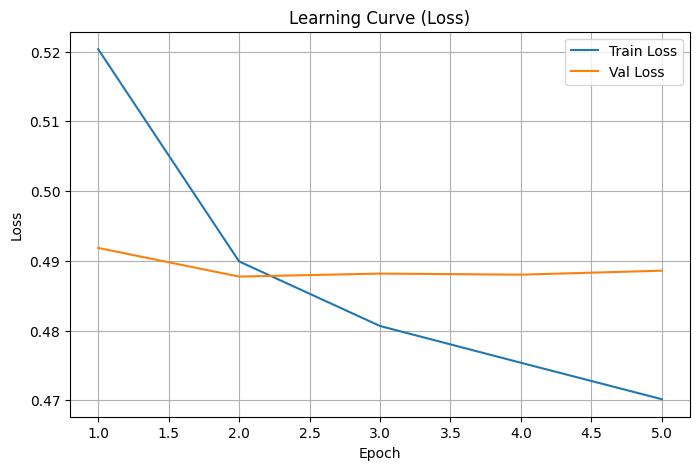

In [49]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()
plt.grid(True)
plt.savefig(pic_path)
plt.show()

### 3.1.2. LSAP with multi head attention

In [50]:
multihead_model = LSAPModelWithMultiHead(
                                hidden_size=768,
                                num_labels=3,
                                num_heads=16,        # 16 attention heads
                                dropout=0.2,
                                attn_dropout=0.2,
                                use_residual=True
                            )

model_path = "/kaggle/working/Model_Checkpoint"
os.makedirs(model_path, exist_ok=True)

model_name = "multi_head_lsap.pt"
save_path = os.path.join(model_path, model_name)
trained_multihead_model, history = train_model(model = multihead_model, num_epochs=epochs, device = device, train_loader=train_windowed_sentence_loader, val_loader=val_windowed_sentence_loader, save_path=save_path)

TypeError: 'range' object cannot be interpreted as an integer

In [ ]:
learning_curve_path = "/kaggle/working/learning_curve_pic"
os.makedirs(learning_curve_path, exist_ok=True)

pic_name = "lsap_multihead_learning_curve.png"
pic_path = os.path.join(learning_curve_path, pic_name)

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()
plt.grid(True)
plt.savefig(pic_path)
plt.show()

### 3.1.3 LSAP Multiple head attention + enhance context window

In [ ]:
multihead_model_enhance_window = LSAPModelWithMultiHead(
                                hidden_size=768,
                                num_labels=3,
                                num_heads=16,        # 16 attention heads
                                dropout=0.4,
                                attn_dropout=0.2,
                                use_residual=True,
                                enhance_context_fused=True
                            )
model_path = "/kaggle/working/Model_Checkpoint"
os.makedirs(model_path, exist_ok=True)

model_name = "16_head_lsap_enhance_window.pt"
save_path = os.path.join(model_path, model_name)
trained_multihead_model_enhance_window, history = train_model(model = multihead_model_enhance_window, num_epochs=epochs, device = device, train_loader=train_windowed_sentence_loader, val_loader=val_windowed_sentence_loader, save_path=save_path)

In [ ]:
learning_curve_path = "/kaggle/working/learning_curve_pic"
os.makedirs(learning_curve_path, exist_ok=True)

pic_name = "lsap_multihead_enhancewind_learning_curve.png"
pic_path = os.path.join(learning_curve_path, pic_name)

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()
plt.grid(True)
plt.savefig(pic_path)
plt.show()

# 4. Test result

In [ ]:
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
print(device)

## 4.1. LSAP with one head attention

In [ ]:
val_loss, val_acc, precision, recall, f1 = validate_model(model=trained_lsap_model_onehead, val_loader=test_windowed_sentence_loader, criterion=criterion, device=device,test=True)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

## 4.2. LSAP with multihead attention

In [ ]:
# val_loss, val_acc, precision, recall, f1 = validate_model(model=trained_multihead_model, val_loader=test_windowed_sentence_loader, criterion=criterion, device=device)
# print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

val_loss, val_acc, precision, recall, f1 = validate_model(model=trained_multihead_model, val_loader=test_windowed_sentence_loader, criterion=criterion, device=device,test=True)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

## 4.3. LSAP with multihead attetion and enhance window

In [ ]:
# val_loss, val_acc, precision, recall, f1 = validate_model(model=trained_multihead_model_enhance_window, val_loader=test_windowed_sentence_loader, criterion=criterion, device=device)
# print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

val_loss, val_acc, precision, recall, f1 = validate_model(model=trained_multihead_model_enhance_window, val_loader=test_windowed_sentence_loader, criterion=criterion, device=device,test=True)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")